In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import lasio
import seaborn as sns
import bruges as br
import ipdb

%matplotlib inline

# Define a default font for the figures
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 12
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

# Initialize Plotly and Cufflinks
from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [144]:
# Load well data

# BO-2X
bo2 = lasio.read('BO-2X.las').df()
bo2 = bo2[['DT','DTDS','PHIE','SW_CRETSYS','VSHALE','ZDEN']] # Extract relevant logs
bo2 = bo2.astype(float) # Convert data type to float number
bo2[['DTDS']] = bo2[['DTDS']].apply(lambda x: x * 3.28084) # us/ft --> us/m

# BO-3X
bo3 = lasio.read('BO-3X.las').df()
bo3 = bo3[['DT','DTS','PHIE','SW_CRETSYS','VSHALE','RHOB']] # Extract relevant logs
bo3 = bo3.astype(float) # Convert data type to float number
bo3[['DTS']] = bo3[['DTS']].apply(lambda x: x * 3.28084) # us/ft --> us/m

# Jude-1
jude1 = lasio.read('Jude-1.las').df()
jude1 = jude1[['DTC','DTS','VSH','SWT','PHIT','DENS']] # Extract relevant logs
jude1[['DTC','DTS']] = jude1[['DTC','DTS']].apply(lambda x: x * 3.28084) # us/ft --> us/m
jude1 = jude1.astype(float) # Convert data type to float number
jude1.index = jude1.index * 0.3048 # ft --> m



Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.


In [460]:
# Log editing: despiking and smoothing

def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolled = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        
        return rolled
    
window = 13 # the length of filter is 13 samples or ~ 2 metres

# Smooth density
rho_sm = np.median(rolling_window(bo2['ZDEN'],window), -1) # Smooths the logs using a median filter
bo2['rho_sm'] = np.pad(rho_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size
rho_sm = np.median(rolling_window(bo3['RHOB'],window), -1)
bo3['rho_sm'] = np.pad(rho_sm, np.int(window/2), mode='edge') 
rho_sm = np.median(rolling_window(jude1['DENS'],window), -1) 
jude1['rho_sm'] = np.pad(rho_sm, np.int(window/2), mode='edge')

# Smooth P-sonic
dt_sm = np.median(rolling_window(bo2['DT'],window), -1) # Smooths the logs using a median filter
bo2['DT_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size
dt_sm = np.median(rolling_window(bo3['DT'],window), -1)
bo3['DT_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge')
dt_sm = np.median(rolling_window(jude1['DTC'],window), -1)
jude1['DT_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge')

# Smooth S-sonic
dt_sm = np.median(rolling_window(bo2['DTDS'],window), -1) # Smooths the logs using a median filter
bo2['DTS_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size
dt_sm = np.median(rolling_window(bo3['DTS'],window), -1)
bo3['DTS_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge')
dt_sm = np.median(rolling_window(jude1['DTS'],window), -1)
jude1['DTS_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge')

# Despike function
def despike(curve, curve_sm, max_clip): 
    spikes = np.where(curve - curve_sm > max_clip)[0]
    spukes = np.where(curve_sm - curve > max_clip)[0]
    out = np.copy(curve)
    out[spikes] = curve_sm.iloc[spikes] + max_clip  # Clip at the max allowed diff
    out[spukes] = curve_sm.iloc[spukes] - max_clip  # Clip at the min allowed diff
    return out

bo2['rho_edt'] = despike(bo2['ZDEN'],bo2['rho_sm'],max_clip = 0.1)
bo2['DT_edt'] = despike(bo2['DT'],bo2['DT_sm'],max_clip = 40)
bo2['DTS_edt'] = despike(bo2['DTDS'],bo2['DTS_sm'],max_clip = 40)

bo3['rho_edt'] = despike(bo3['RHOB'],bo3['rho_sm'],max_clip = 0.1)
bo3['DT_edt'] = despike(bo3['DT'],bo3['DT_sm'],max_clip = 40)
bo3['DTS_edt'] = despike(bo3['DTS'],bo3['DTS_sm'],max_clip = 40)

jude1['rho_edt'] = despike(jude1['DENS'],jude1['rho_sm'],max_clip = 0.05)
jude1['DT_edt'] = despike(jude1['DTC'],jude1['DT_sm'],max_clip = 20)
jude1['DTS_edt'] = despike(jude1['DTS'],jude1['DTS_sm'],max_clip = 20)


C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

Series.strides is deprecated and will be removed in a future version

C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning:

Invalid value encountered in median for 4963 results

C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning:

Invalid value encountered in median for 725 results

C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning:

Invalid value encountered in median for 536 results

C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning:

Invalid value encountered in median for 328 results

C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning:

Invalid value encountered in median for 632 results

C:\Users\kenb\Pytho

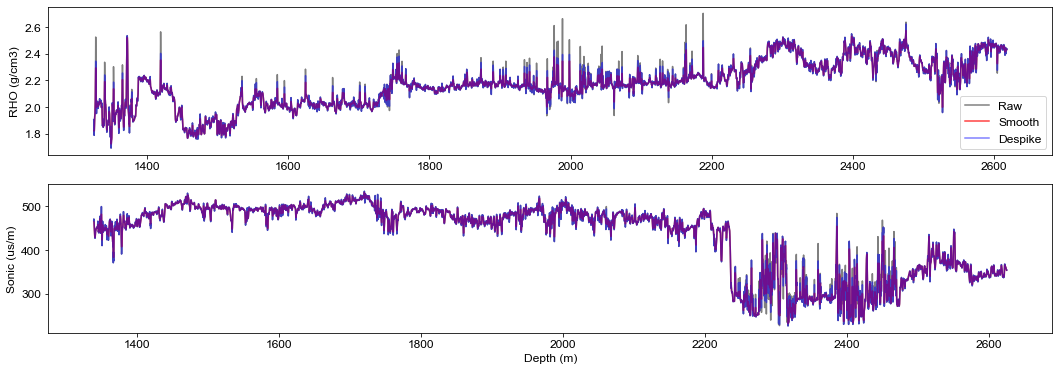

In [461]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(18,6))
axes[0].plot(jude1.index,jude1['DENS'], 'k',alpha=0.5,label='Raw')
axes[0].plot(jude1.index,jude1['rho_sm'], 'r',alpha=0.75,label='Smooth')
axes[0].plot(jude1.index,jude1['rho_edt'], 'b',alpha=0.5,label='Despike')
axes[0].set_ylabel('RHO (g/cm3)')
axes[0].axis('tight')
axes[0].legend(loc=0)
axes[1].plot(jude1.index,jude1['DTC'],'k',alpha=0.5)
axes[1].plot(jude1.index,jude1['DT_sm'],'r',alpha=0.75)
axes[1].plot(jude1.index,jude1['DT_edt'], 'b',alpha=0.5)
axes[1].set_xlabel('Depth (m)')
axes[1].set_ylabel('Sonic (us/m)')
axes[1].axis('tight')

plt.show()

In [462]:
# Define main formation tops

tops = pd.DataFrame([[2330.393, 2356.22, 2373.93, 2430.51, 2555.35],[2429.8656, np.nan , 2519.4768, 2574.9504, 2720.34]],
                    ['BO2','JUDE1'],['Hidra','Sola','Tuxen','Valhall','BCU'])

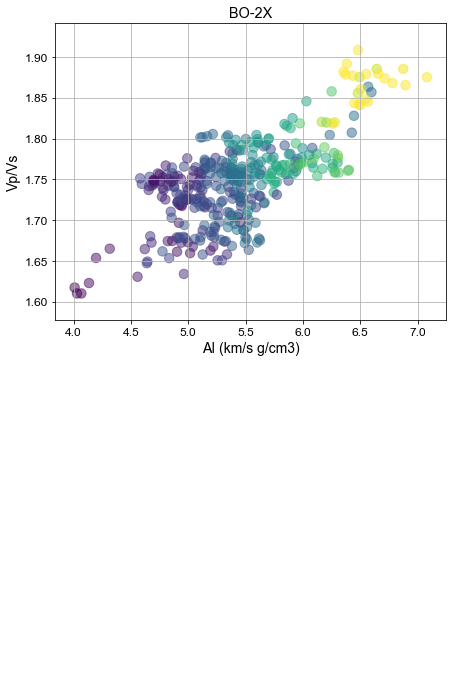

In [565]:
# Define elastic logs
bo2['Vp'] = (1e3 / bo2['DT_edt'])
bo2['Vs'] = (1e3 / bo2['DTS_edt'])
bo2['AI'] = bo2['Vp'] * bo2['rho_edt']
bo2['PS'] = bo2['Vp'] / bo2['Vs']

bo2['G'] = bo2['Vs']**2 * bo2['rho_edt']
bo2['K'] = bo2['Vp']**2 * bo2['rho_edt'] - (4/3)*bo2['G']
bo2['M'] = bo2['K'] + (4/3)*bo2['G']

# Crop reservoir interval
bo2_resSec = bo2[(bo2.index > tops[['Tuxen']].loc['BO2'][0]) & (bo2.index < tops[['Valhall']].loc['BO2'][0])]

fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize=(7,12))

sc = ax[0].scatter(bo2_resSec['AI'],bo2_resSec['PS'],alpha=0.5,s=90,c=bo2_resSec['SW_CRETSYS'])
ax[0].set_xlabel('AI (km/s g/cm3)',fontsize=14)
ax[0].set_ylabel('Vp/Vs',fontsize=14)
ax[0].set_title('BO-2X')
ax[0].grid()
ax[0].axis('tight')

ax[1].axis('off')

plt.show()


In [566]:
# Crop reservoir interval
bo2_resSec = bo2[(bo2.index > tops[['Tuxen']].loc['BO2'][0] - 20) & (bo2.index < tops[['Valhall']].loc['BO2'][0] + 20)]

# Subdivide reservoir zonations
bo2_resSec['F'] = np.zeros(len(bo2_resSec))
bo2_resSec['F_label'] = ["" for x in range(len(bo2_resSec))]
bo2_intf = [tops['Tuxen'].loc['BO2'], 2380.2, 2387.1, 2391.6, 2397.1,2398.2,2406.5,2420.1,2426.9] # interfaces
bo2_Fstr = 'Sola,UT,MTbU,MTbL,MTa,MM,LTd,LTc,LTb,Valhall'
bo2_Fstr = bo2_Fstr.split(',')

bo2_resSec.loc[(bo2_resSec.index < bo2_intf[0]),'F'] = 0
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[0]) & (bo2_resSec.index <= bo2_intf[1]),'F'] = 1
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[1]) & (bo2_resSec.index <= bo2_intf[2]),'F'] = 2
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[2]) & (bo2_resSec.index <= bo2_intf[3]),'F'] = 3
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[3]) & (bo2_resSec.index <= bo2_intf[4]),'F'] = 4
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[4]) & (bo2_resSec.index <= bo2_intf[5]),'F'] = 5
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[5]) & (bo2_resSec.index <= bo2_intf[6]),'F'] = 6
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[6]) & (bo2_resSec.index <= bo2_intf[7]),'F'] = 7
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[7]) & (bo2_resSec.index <= bo2_intf[8]),'F'] = 8
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[8]),'F'] = 9

bo2_resSec.loc[(bo2_resSec.index < bo2_intf[0]),'F_label'] = bo2_Fstr[0]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[0]) & (bo2_resSec.index <= bo2_intf[1]),'F_label'] = bo2_Fstr[1]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[1]) & (bo2_resSec.index <= bo2_intf[2]),'F_label'] = bo2_Fstr[2]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[2]) & (bo2_resSec.index <= bo2_intf[3]),'F_label'] = bo2_Fstr[3]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[3]) & (bo2_resSec.index <= bo2_intf[4]),'F_label'] = bo2_Fstr[4]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[4]) & (bo2_resSec.index <= bo2_intf[5]),'F_label'] = bo2_Fstr[5]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[5]) & (bo2_resSec.index <= bo2_intf[6]),'F_label'] = bo2_Fstr[6]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[6]) & (bo2_resSec.index <= bo2_intf[7]),'F_label'] = bo2_Fstr[7]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[7]) & (bo2_resSec.index <= bo2_intf[8]),'F_label'] = bo2_Fstr[8]
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[8]),'F_label'] = bo2_Fstr[9]

bo2_dz = []
for m in range(0,len(bo2_Fstr)):
    bo2_dz.append(np.diff(bo2_resSec[bo2_resSec['F']==m].index).sum())


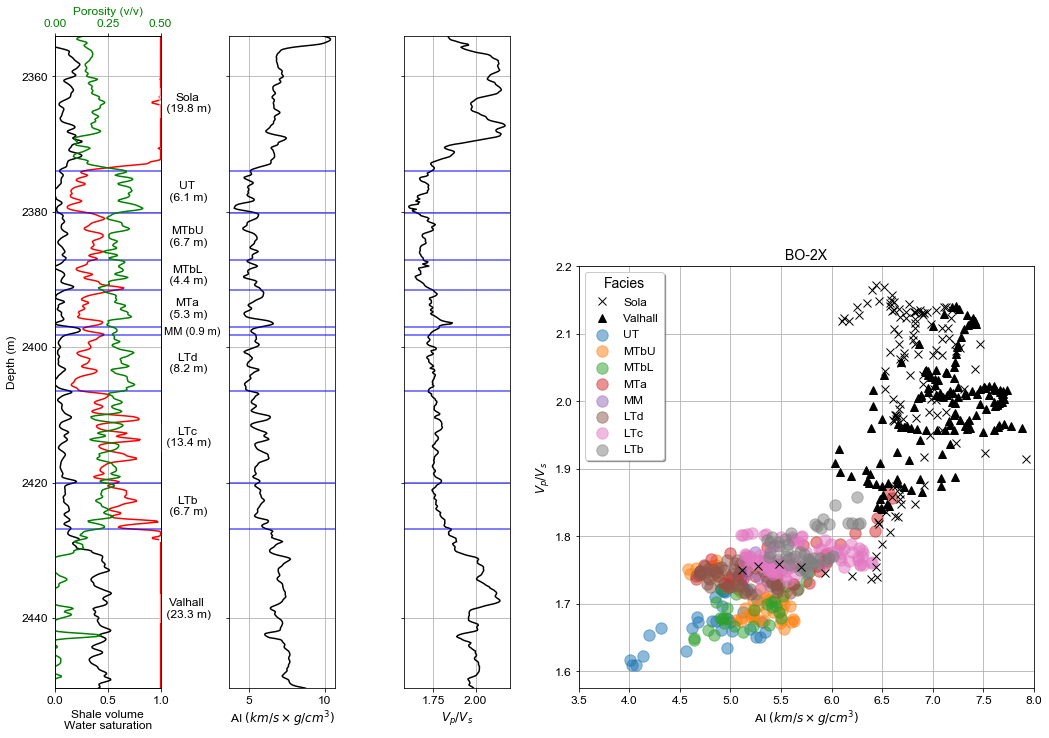

In [567]:
fig = plt.figure(figsize=(16,12))
#
gs1 = gridspec.GridSpec(nrows=3, ncols=6, left = 0.05, wspace=0.65)
ax1a = fig.add_subplot(gs1[:, 0])
ax2 = fig.add_subplot(gs1[:, 1])
ax3 = fig.add_subplot(gs1[:, 2])
ax4 = fig.add_subplot(gs1[1:3, 3:6])

# Shale volume & water saturation
ax1a.plot(bo2_resSec['VSHALE'],bo2_resSec.index,'k-')
ax1a.axis('tight')
ax1a.set_ylim(bo2_resSec.index.min(),bo2_resSec.index.max())
ax1a.invert_yaxis()
ax1a.set_xlim(0,1)
ax1a.set_xlabel('Shale volume\nWater saturation', fontsize = 12)
ax1a.set_ylabel('Depth (m)', fontsize = 12)
ax1a.grid()
ax1a.plot(bo2_resSec['SW_CRETSYS'],bo2_resSec.index,'r-')

#Porosity
ax1b = ax1a.twiny()  # instantiate a second axes that shares the same x-axis
ax1b.plot(bo2_resSec['PHIE'],bo2_resSec.index,'g-')
ax1b.tick_params(axis='x', labelcolor='g')
ax1b.set_xlabel('Porosity (v/v)', FontSize = 12, color = 'g')
ax1b.set_xlim(0,0.5)


# AI
ax2.plot(bo2_resSec['AI'],bo2_resSec.index,'k-')
ax2.axis('tight')
ax2.set_ylim(bo2_resSec.index.min(),bo2_resSec.index.max())
ax2.invert_yaxis()
ax2.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax2.set_yticklabels('')
ax2.grid()

# Vp/Vs
ax3.plot(bo2_resSec['PS'],bo2_resSec.index,'k-')
ax3.axis('tight')
ax3.set_ylim(bo2_resSec.index.min(),bo2_resSec.index.max())
ax3.invert_yaxis()
ax3.set_xlabel(r'$V_p/V_s$', fontsize = 12)
ax3.set_yticklabels('')
ax3.grid()

for n in range(0,len(bo2_intf)):
    ax1a.axhline(y = bo2_intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)    
    ax2.axhline(y = bo2_intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)
    ax3.axhline(y = bo2_intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)
    


    
ax1a.text(x = ax1a.set_xlim()[1]+0.25, y = (bo2_intf[0] + bo2_resSec.index.min())/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[0],str(round(bo2_dz[0],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(bo2_intf[0]+bo2_intf[1])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[1],str(round(bo2_dz[1],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(bo2_intf[1]+bo2_intf[2])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[2],str(round(bo2_dz[2],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(bo2_intf[2]+bo2_intf[3])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[3],str(round(bo2_dz[3],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(bo2_intf[3]+bo2_intf[4])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[4],str(round(bo2_dz[4],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.3, y =(bo2_intf[4]+bo2_intf[5])/2, s = '{0} ({1} m)'.format(bo2_Fstr[5],str(round(bo2_dz[5],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(bo2_intf[5]+bo2_intf[6])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[6],str(round(bo2_dz[6],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(bo2_intf[6]+bo2_intf[7])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[7],str(round(bo2_dz[7],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(bo2_intf[7]+bo2_intf[8])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[8],str(round(bo2_dz[8],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(bo2_intf[8]+bo2_resSec.index.max())/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[9],str(round(bo2_dz[9],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)


# AI vs Vp/Vs

groups = bo2_resSec['F_label'].unique()

for i in range(len(groups)):
    x, y = (bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'])
    if (groups[i]=='Sola'):
        ax4.plot(bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'],'kx',ms=8,label=groups[i])
    elif (groups[i]=='Valhall'):
        ax4.plot(bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'],'k^',ms=8,label=groups[i],color='k')
    else:
        ax4.scatter(x, y, alpha=0.5, s=130, label=groups[i])


ax4.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax4.set_ylabel(r'$V_p/V_s$', fontsize = 12)
ax4.set_title('BO-2X',fontsize=14)
ax4.set_xlim(3.5,8)
ax4.grid()
ax4.set_axisbelow(True)
lg = ax4.legend(loc=2,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

#plt.savefig('Bo2_x-plot.png',dpi=400)
plt.show()

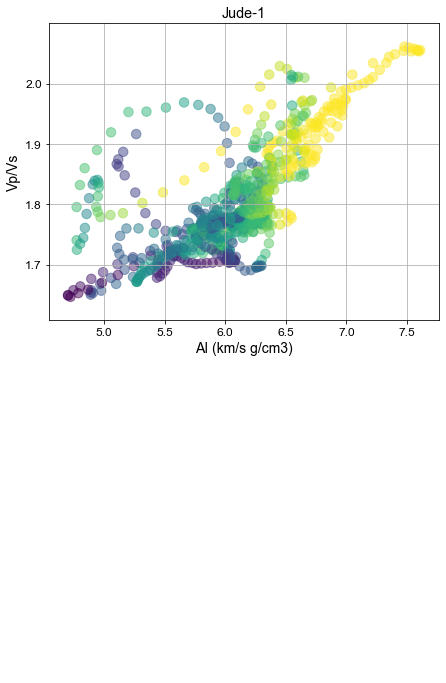

In [568]:
# Define elastic logs
jude1['Vp'] = (1e3 / jude1['DT_edt'])
jude1['Vs'] = (1e3 / jude1['DTS_edt'])
jude1['AI'] = jude1['Vp'] * jude1['rho_edt']
jude1['PS'] = jude1['Vp'] / jude1['Vs']

jude1['G'] = jude1['Vs']**2 * jude1['rho_edt']
jude1['K'] = jude1['Vp']**2 * jude1['rho_edt'] - (4/3)*jude1['G']
jude1['M'] = jude1['K'] + (4/3)*jude1['G']

# Crop reservoir interval
jude1_resSec = jude1[(jude1.index > tops[['Tuxen']].loc['JUDE1'][0]) & (jude1.index < tops[['Valhall']].loc['JUDE1'][0])]


fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize=(7,12))

sc = ax[0].scatter(jude1_resSec['AI'],jude1_resSec['PS'],alpha=0.5,s=90,c=jude1_resSec['SWT'])
ax[0].set_xlabel('AI (km/s g/cm3)',fontsize=14)
ax[0].set_ylabel('Vp/Vs',fontsize=14)
ax[0].set_title('Jude-1')
ax[0].grid()
ax[0].axis('tight')

ax[1].axis('off')

plt.show()


In [569]:
# Crop reservoir interval
jude1_resSec = jude1[(jude1.index > tops[['Tuxen']].loc['JUDE1'][0] - 20) & (jude1.index < tops[['Valhall']].loc['JUDE1'][0] + 20)]

# Subdivide reservoir zonations
jude1_resSec['F'] = np.zeros(len(jude1_resSec))
jude1_resSec['F_label'] = ["" for x in range(len(jude1_resSec))]
jude1_intf = [tops['Tuxen'].loc['JUDE1'], 2527.09, 2534.41, 2541.72, 2550.26,2552.70,2561.84,2568.55,2574.95] # interfaces
jude1_Fstr = 'Sola,UT,MTbU,MTbL,MTa,MM,LTd,LTc,LTb,Valhall'
jude1_Fstr = jude1_Fstr.split(',')

jude1_resSec.loc[(jude1_resSec.index < jude1_intf[0]),'F'] = 0
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[0]) & (jude1_resSec.index <= jude1_intf[1]),'F'] = 1
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[1]) & (jude1_resSec.index <= jude1_intf[2]),'F'] = 2
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[2]) & (jude1_resSec.index <= jude1_intf[3]),'F'] = 3
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[3]) & (jude1_resSec.index <= jude1_intf[4]),'F'] = 4
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[4]) & (jude1_resSec.index <= jude1_intf[5]),'F'] = 5
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[5]) & (jude1_resSec.index <= jude1_intf[6]),'F'] = 6
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[6]) & (jude1_resSec.index <= jude1_intf[7]),'F'] = 7
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[7]) & (jude1_resSec.index <= jude1_intf[8]),'F'] = 8
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[8]),'F'] = 9

jude1_resSec.loc[(jude1_resSec.index < jude1_intf[0]),'F_label'] = jude1_Fstr[0]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[0]) & (jude1_resSec.index <= jude1_intf[1]),'F_label'] = jude1_Fstr[1]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[1]) & (jude1_resSec.index <= jude1_intf[2]),'F_label'] = jude1_Fstr[2]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[2]) & (jude1_resSec.index <= jude1_intf[3]),'F_label'] = jude1_Fstr[3]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[3]) & (jude1_resSec.index <= jude1_intf[4]),'F_label'] = jude1_Fstr[4]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[4]) & (jude1_resSec.index <= jude1_intf[5]),'F_label'] = jude1_Fstr[5]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[5]) & (jude1_resSec.index <= jude1_intf[6]),'F_label'] = jude1_Fstr[6]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[6]) & (jude1_resSec.index <= jude1_intf[7]),'F_label'] = jude1_Fstr[7]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[7]) & (jude1_resSec.index <= jude1_intf[8]),'F_label'] = jude1_Fstr[8]
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[8]),'F_label'] = jude1_Fstr[9]

jude1_dz = []
for m in range(0,len(jude1_Fstr)):
    jude1_dz.append(np.diff(jude1_resSec[jude1_resSec['F']==m].index).sum())


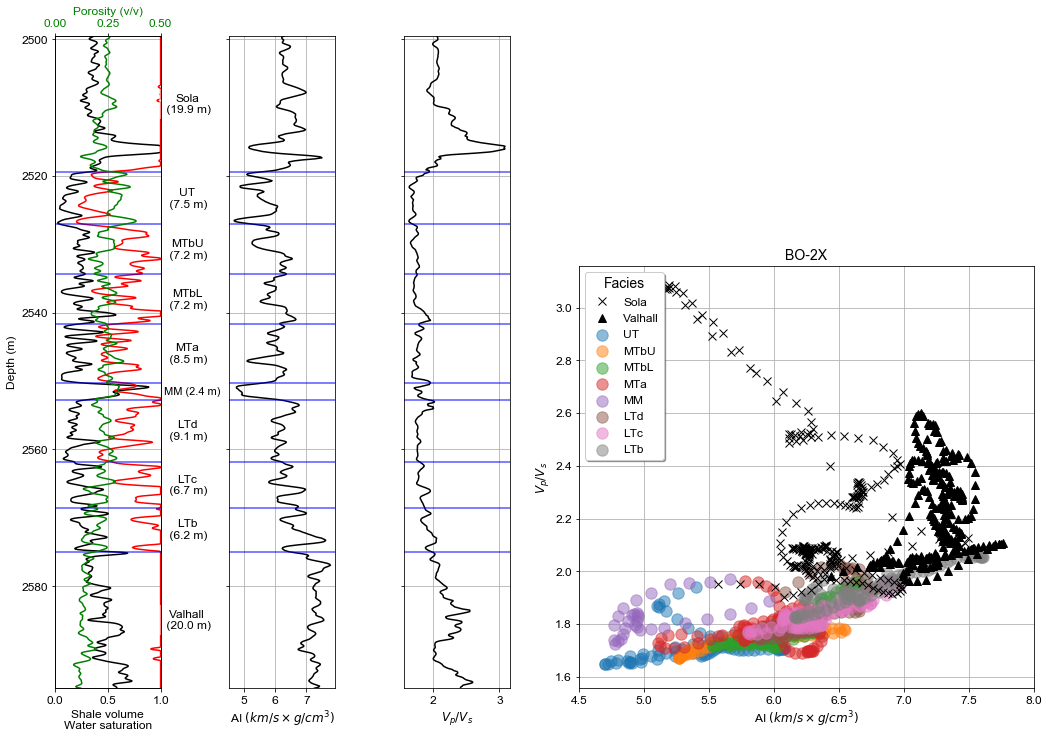

In [570]:
fig = plt.figure(figsize=(16,12))
#
gs1 = gridspec.GridSpec(nrows=3, ncols=6, left = 0.05, wspace=0.65)
ax1a = fig.add_subplot(gs1[:, 0])
ax2 = fig.add_subplot(gs1[:, 1])
ax3 = fig.add_subplot(gs1[:, 2])
ax4 = fig.add_subplot(gs1[1:3, 3:6])

# Shale volume & water saturation
ax1a.plot(jude1_resSec['VSH'],jude1_resSec.index,'k-')
ax1a.axis('tight')
ax1a.set_ylim(jude1_resSec.index.min(),jude1_resSec.index.max())
ax1a.invert_yaxis()
ax1a.set_xlim(0,1)
ax1a.set_xlabel('Shale volume\nWater saturation', fontsize = 12)
ax1a.set_ylabel('Depth (m)', fontsize = 12)
ax1a.grid()
ax1a.plot(jude1_resSec['SWT'],jude1_resSec.index,'r-')

#Porosity
ax1b = ax1a.twiny()  # instantiate a second axes that shares the same x-axis
ax1b.plot(jude1_resSec['PHIT'],jude1_resSec.index,'g-')
ax1b.tick_params(axis='x', labelcolor='g')
ax1b.set_xlabel('Porosity (v/v)', FontSize = 12, color = 'g')
ax1b.set_xlim(0,0.5)

# AI
ax2.plot(jude1_resSec['AI'],jude1_resSec.index,'k-')
ax2.axis('tight')
ax2.set_ylim(jude1_resSec.index.min(),jude1_resSec.index.max())
ax2.invert_yaxis()
ax2.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax2.set_yticklabels('')
ax2.grid()

# Vp/Vs
ax3.plot(jude1_resSec['PS'],jude1_resSec.index,'k-')
ax3.axis('tight')
ax3.set_ylim(jude1_resSec.index.min(),jude1_resSec.index.max())
ax3.invert_yaxis()
ax3.set_xlabel(r'$V_p/V_s$', fontsize = 12)
ax3.set_yticklabels('')
ax3.grid()

for n in range(0,len(jude1_intf)):
    ax1a.axhline(y = jude1_intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)    
    ax2.axhline(y = jude1_intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)
    ax3.axhline(y = jude1_intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)
    


    
ax1a.text(x = ax1a.set_xlim()[1]+0.25, y = (jude1_intf[0] + jude1_resSec.index.min())/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[0],str(round(jude1_dz[0],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(jude1_intf[0]+jude1_intf[1])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[1],str(round(jude1_dz[1],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(jude1_intf[1]+jude1_intf[2])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[2],str(round(jude1_dz[2],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(jude1_intf[2]+jude1_intf[3])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[3],str(round(jude1_dz[3],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(jude1_intf[3]+jude1_intf[4])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[4],str(round(jude1_dz[4],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.3, y =(jude1_intf[4]+jude1_intf[5])/2, s = '{0} ({1} m)'.format(jude1_Fstr[5],str(round(jude1_dz[5],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(jude1_intf[5]+jude1_intf[6])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[6],str(round(jude1_dz[6],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(jude1_intf[6]+jude1_intf[7])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[7],str(round(jude1_dz[7],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(jude1_intf[7]+jude1_intf[8])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[8],str(round(jude1_dz[8],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.25, y =(jude1_intf[8]+jude1_resSec.index.max())/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[9],str(round(jude1_dz[9],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0),
        weight = 'light',
        rotation=0)


# AI vs Vp/Vs

groups = jude1_resSec['F_label'].unique()

for i in range(len(groups)):
    x, y = (jude1_resSec[jude1_resSec['F_label']==groups[i]]['AI'],jude1_resSec[jude1_resSec['F_label']==groups[i]]['PS'])
    if (groups[i]=='Sola'):
        ax4.plot(jude1_resSec[jude1_resSec['F_label']==groups[i]]['AI'],jude1_resSec[jude1_resSec['F_label']==groups[i]]['PS'],'kx',ms=8,label=groups[i])
    elif (groups[i]=='Valhall'):
        ax4.plot(jude1_resSec[jude1_resSec['F_label']==groups[i]]['AI'],jude1_resSec[jude1_resSec['F_label']==groups[i]]['PS'],'k^',ms=8,label=groups[i],color='k')
    else:
        ax4.scatter(x, y, alpha=0.5, s=130, label=groups[i])


ax4.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax4.set_ylabel(r'$V_p/V_s$', fontsize = 12)
ax4.set_title('BO-2X',fontsize=14)
ax4.set_xlim(4.5,8)
ax4.grid()
ax4.set_axisbelow(True)
lg = ax4.legend(loc=0,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

#plt.savefig('jude1_x-plot.png',dpi=400)
plt.show()

In [571]:
# Physical properties of constituents

K_o=0.82     # oil
Rho_o=0.8

K_w=2.2
G_w=0         # water
Rho_w=1.0

K_ca=71  
G_ca=30       # calcite
Rho_ca=2.71

K_q=37.3  
G_q=44.8      # quartz
Rho_q=2.65

K_k=28.1  
G_k=10.5       # kaolinite
Rho_k=2.6

K_s=28.7  
G_s=10.8       # smectite
Rho_s=2.6

# Volume fraction of large calcite and large silicates 
c_l = 0.3 # large calcite
q_l = 0.1 # large quartz
k_l = 0.05 # large kaolinite

# Volume fraction of small calcite and suspended silicates
c_s = 0.4 # small calcite
q_s = 0.05 # small quartz
k_s = 0.05 # small kaolinite
s_s = 0.05 # small smectite

print('Total volume fraction of solids equals: ', np.round(c_l+q_l+k_l+c_s+q_s+k_s+s_s,0))

# Reservoir properties
Por_c = 0.66 # Critical porosity
Por=np.linspace(0,Por_c,100)
S_w = 0.2 # water saturation
fluidMix = 'patchy'

Total volume fraction of solids equals:  1.0


In [572]:
# Modeling

K_sus = np.nan*np.ones((Por.size,11))
K_IF = np.nan*np.ones((Por.size,11))
G_IF = np.nan*np.ones((Por.size,11))
M_IF = np.nan*np.ones((Por.size,11))
Vp_IF = np.nan*np.ones((Por.size,11))
Vs_IF = np.nan*np.ones((Por.size,11))
AI_IF = np.nan*np.ones((Por.size,11))
PS_IF = np.nan*np.ones((Por.size,11))
Rho = np.nan*np.ones((Por.size,11))

n=0;
for IF in np.arange(0,1.1,0.1):
    
    if fluidMix == 'patchy':
        K_f = S_w*K_w + (1-S_w)*K_o; # Patchy Voigt mixing the water and oil
        
        # Homogeneous Reuss mixing of fluid and suspended minerals
        K_sus[:,n] = ( (Por/Por_c)/K_f + (1-Por/Por_c)*((c_s*(1-IF)/K_ca) + (q_s/K_q) + (k_s/K_k) + (s_s/K_s)) )**(-1) * (Por/Por_c + (1-Por/Por_c)*(c_s*(1-IF) + q_s + k_s + s_s) )
        
    else:
        K_sus[:,n] = ( Por/Por_c*((S_w/K_w) + ((1-S_w)/K_o)) + (1-Por/Por_c)*((c_s*(1-IF)/K_ca) + (q_s/K_q) + (k_s/K_k) + (s_s/K_s)) )**(-1) * (Por/Por_c + (1-Por/Por_c)*(c_s*(1-IF) + q_s + k_s + s_s) )
    
    Rho[:,n] = (Por/Por_c)*((1-IF)*c_s*Rho_ca + (Rho_w*S_w) + (Rho_o*(1-S_w)) + Rho_s*s_s + Rho_k*k_s + Rho_q*q_s) + (1-(Por/Por_c))*((IF*c_s+c_l)*Rho_ca + q_l*Rho_q + k_l*Rho_k);

    K_IF[:,n] = ( ((Por/Por_c)/(K_sus[:,n] + (4/3)*G_ca)) + (1-(Por/Por_c))* ( (((1-IF)*c_s + s_s + q_s + k_s)/(K_sus[:,n] + (4/3)*G_ca)) + ((IF*c_s+c_l)/(K_ca + (4/3)*G_ca)) + (q_l / (K_q + (4/3)*G_ca)) + (k_l / (K_k + (4/3)*G_ca)) ))**(-1) - (4/3)*G_ca

    zeta = (G_ca/6) * ((9*K_ca + 8*G_ca)/(K_ca + 2*G_ca));

    G_IF[:,n] = ( ((Por/Por_c)/zeta) +  (1-(Por/Por_c))*( (((1-IF)*c_s + s_s + q_s + k_s)/(zeta)) + ((IF*c_s+c_l)/(G_ca + zeta)) + (q_l/(G_q + zeta)) + (k_l / (G_k + zeta))) )**(-1) - zeta;
        
    M_IF[:,n] = K_IF[:,n] + (4/3)*G_IF[:,n]
    
    Vp_IF[:,n] = np.sqrt(K_IF[:,n] + (4/3)*G_IF[:,n] / Rho[:,n])
    Vs_IF[:,n] = np.sqrt(G_IF[:,n] / Rho[:,n])
    
    AI_IF[:,n] = Vp_IF[:,n] * Rho[:,n]
    PS_IF[:,n] = Vp_IF[:,n] / Vs_IF[:,n]
    
    n=n+1
    



C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

divide by zero encountered in true_divide



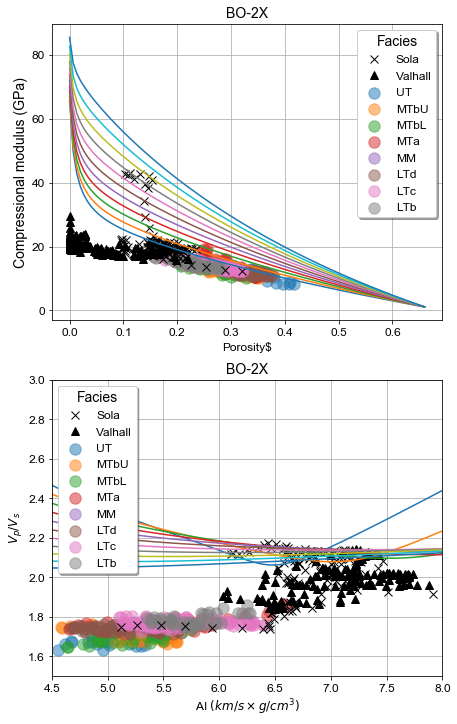

In [580]:
# Plot model vs data

fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize=(7,12))

groups = bo2_resSec['F_label'].unique()

for i in range(len(groups)):
    x, y = (bo2_resSec[bo2_resSec['F_label']==groups[i]]['PHIE'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['M'])
    if (groups[i]=='Sola'):
        ax[0].plot(bo2_resSec[bo2_resSec['F_label']==groups[i]]['PHIE'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['M'],'kx',ms=8,label=groups[i])
    elif (groups[i]=='Valhall'):
        ax[0].plot(bo2_resSec[bo2_resSec['F_label']==groups[i]]['PHIE'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['M'],'k^',ms=8,label=groups[i],color='k')
    else:
        ax[0].scatter(x, y, alpha=0.5, s=130, label=groups[i])
        
ax[0].plot(Por,M_IF)      
ax[0].set_xlabel('Porosity$', fontsize = 12)
ax[0].set_ylabel('Compressional modulus (GPa)', fontsize = 14)
ax[0].set_title('BO-2X',fontsize=14)

ax[0].grid()
ax[0].set_axisbelow(True)
lg = ax[0].legend(loc=0,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

for i in range(len(groups)):
    x, y = (bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'])
    if (groups[i]=='Sola'):
        ax[1].plot(bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'],'kx',ms=8,label=groups[i])
    elif (groups[i]=='Valhall'):
        ax[1].plot(bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'],'k^',ms=8,label=groups[i],color='k')
    else:
        ax[1].scatter(x, y, alpha=0.5, s=130, label=groups[i])

ax[1].plot(AI_IF,PS_IF)      
ax[1].set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax[1].set_ylabel(r'$V_p/V_s$', fontsize = 12)
ax[1].set_title('BO-2X',fontsize=14)
ax[1].set_xlim(4.5,8)
ax[1].set_ylim(1.5,3)
ax[1].grid()
ax[1].set_axisbelow(True)
lg = ax[1].legend(loc=0,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

#plt.savefig('jude1_x-plot.png',dpi=400)
plt.show()

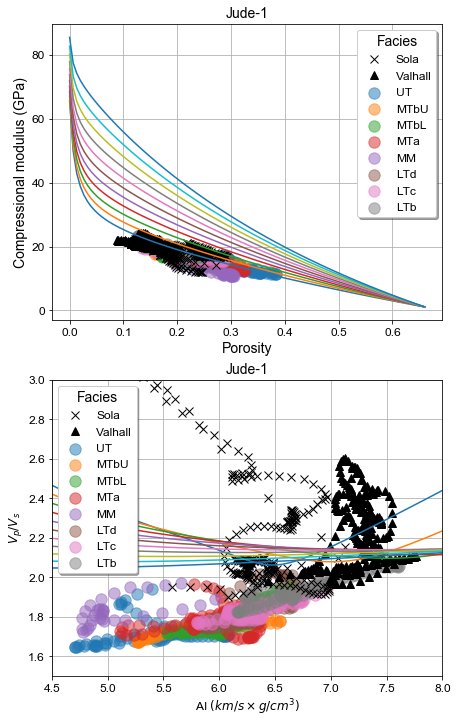

In [579]:
# Plot model vs data

fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize=(7,12))

groups = jude1_resSec['F_label'].unique()

for i in range(len(groups)):
    x, y = (jude1_resSec[jude1_resSec['F_label']==groups[i]]['PHIT'],jude1_resSec[jude1_resSec['F_label']==groups[i]]['M'])
    if (groups[i]=='Sola'):
        ax[0].plot(jude1_resSec[jude1_resSec['F_label']==groups[i]]['PHIT'],jude1_resSec[jude1_resSec['F_label']==groups[i]]['M'],'kx',ms=8,label=groups[i])
    elif (groups[i]=='Valhall'):
        ax[0].plot(jude1_resSec[jude1_resSec['F_label']==groups[i]]['PHIT'],jude1_resSec[jude1_resSec['F_label']==groups[i]]['M'],'k^',ms=8,label=groups[i],color='k')
    else:
        ax[0].scatter(x, y, alpha=0.5, s=130, label=groups[i])
        
ax[0].plot(Por,M_IF)      
ax[0].set_xlabel('Porosity', fontsize = 14)
ax[0].set_ylabel('Compressional modulus (GPa)', fontsize = 14)
ax[0].set_title('Jude-1',fontsize=14)

ax[0].grid()
ax[0].set_axisbelow(True)
lg = ax[0].legend(loc=0,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

for i in range(len(groups)):
    x, y = (jude1_resSec[jude1_resSec['F_label']==groups[i]]['AI'],jude1_resSec[jude1_resSec['F_label']==groups[i]]['PS'])
    if (groups[i]=='Sola'):
        ax[1].plot(jude1_resSec[jude1_resSec['F_label']==groups[i]]['AI'],jude1_resSec[jude1_resSec['F_label']==groups[i]]['PS'],'kx',ms=8,label=groups[i])
    elif (groups[i]=='Valhall'):
        ax[1].plot(jude1_resSec[jude1_resSec['F_label']==groups[i]]['AI'],jude1_resSec[jude1_resSec['F_label']==groups[i]]['PS'],'k^',ms=8,label=groups[i],color='k')
    else:
        ax[1].scatter(x, y, alpha=0.5, s=130, label=groups[i])

ax[1].plot(AI_IF,PS_IF)      
ax[1].set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax[1].set_ylabel(r'$V_p/V_s$', fontsize = 12)
ax[1].set_title('Jude-1',fontsize=14)
ax[1].set_xlim(4.5,8)
ax[1].set_ylim(1.5,3)
ax[1].grid()
ax[1].set_axisbelow(True)
lg = ax[1].legend(loc=0,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

#plt.savefig('jude1_x-plot.png',dpi=400)
plt.show()

# Note 12.08.19

We achieve compressional modulus lines that apparently describes the data trend for the clean chalk reservoir zones (i.e. Upper Tuxen) in a good way. However, if we make a corresponding plot for two parameters, say bulk and shear moduli or Vp and Vs, then the model fits the different data parameters with different IF values, meaning that there is some inconsistency in the model, or, the model calibration is performed based on some incorrect premises. Achieving different IF values for the same data will be problematic when we later want to analyze seismic inversion data composed of the AI and Vp/Vs parameters. Which IF should we chose? The one that fits the Compressional modulus parameter only? Why are there differing IF values for different data parameters in the first place?